In [1]:
# 实战 Kaggle ⽐赛：图像分类 (CIFAR-10)
''' 
之前⼏节中，我们⼀直在使⽤深度学习框架的⾼级API直接获取张量格式的图像数据集。但是在实践中，图
像数据集通常以图像⽂件的形式出现。在本节中，我们将从原始图像⽂件开始，然后逐步组织、读取并将它
们转换为张量格式。
我们在 13.1节中对CIFAR-10数据集做了⼀个实验。CIFAR-10是计算机视觉领域中的⼀个重要的数据集。在
本节中，我们将运⽤我们在前⼏节中学到的知识来参加CIFAR-10图像分类问题的Kaggle竞赛，⽐赛的⽹址
是https://www.kaggle.com/c/cifar-10。
图13.13.1显⽰了竞赛⽹站⻚⾯上的信息。为了能提交结果，你需要⾸先注册Kaggle账⼾

⾸先，导⼊竞赛所需的包和模块
'''
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
# 获取并组织数据集
''' 
⽐赛数据集分为训练集和测试集，其中训练集包含50000张、测试集包含300000张图像。在测试集中，10000张
图像将被⽤于评估，⽽剩下的290000张图像将不会被进⾏评估，包含它们只是为了防⽌⼿动标记测试集并提
交标记结果。两个数据集中的图像都是png格式，⾼度和宽度均为32像素并有三个颜⾊通道（RGB）。这些图
⽚共涵盖10个类别：⻜机、汽⻋、⻦类、猫、⿅、狗、⻘蛙、⻢、船和卡⻋。图13.13.1的左上⻆显⽰了数据
集中⻜机、汽⻋和⻦类的⼀些图像
-------------------------------------------------------------------------------------------
下载数据集

登录Kaggle后，我们可以点击 图13.13.1中显⽰的CIFAR-10图像分类竞赛⽹⻚上的“Data”选项卡，然后单击
“Download All”按钮下载数据集。在../data中解压下载的⽂件并在其中解压缩train.7z和test.7z后，
你将在以下路径中找到整个数据集：
• ../data/cifar-10/train/[1-50000].png
• ../data/cifar-10/test/[1-300000].png
• ../data/cifar-10/trainLabels.csv
• ../data/cifar-10/sampleSubmission.csv
train和test⽂ 件 夹 分 别 包 含 训 练 和 测 试 图 像，trainLabels.csv含 有 训 练 图 像 的 标 签，
sample_submission.csv是提交⽂件的范例。
为了便于⼊⻔，我们提供包含前1000个训练图像和5个随机测试图像的数据集的⼩规模样本。要使⽤Kaggle竞
赛的完整数据集，你需要将以下demo变量设置为False
'''
#@save
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip',
                                '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
# 如果你使⽤完整的Kaggle竞赛的数据集，设置demo为False
demo = True
if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'
    

In [3]:
# 整理数据集
''' 
我们需要整理数据集来训练和测试模型。⾸先，我们⽤以下函数读取CSV⽂件中的标签，它返回⼀个字典，该
字典将⽂件名中不带扩展名的部分映射到其标签
'''
#@save
def read_csv_labels(fname):
    """读取fname来给标签字典返回⼀个⽂件名"""
    with open(fname, 'r') as f: # 引入with语句自动调用close()方法
        # 跳过⽂件头⾏(列名)
        lines = f.readlines()[1:] # 不读取列名
        # 因为每行有一个 \n ，所以要先删除,后根据 ","进行分割得到 list
    tokens = [l.rstrip().split(',') for l in lines] # 去掉右侧尾部的\n,并以','切分字符串
    return dict(((name, label) for name, label in tokens)) # 逐个迭代token,生成字典对

# 将字典对返回给label，做好标签映射
labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv')) # 标签
print(data_dir) # 文件目录
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

../data/kaggle_cifar10_tiny
# 训练样本 : 1000
# 类别 : 10


In [4]:
''' 
接下来，我们定义reorg_train_valid函数来将验证集从原始的训练集中拆分出来。此函数中的参
数valid_ratio是验证集中的样本数与原始训练集中的样本数之⽐。更具体地说，令n等于样本最少的类
别中的图像数量，⽽r是⽐率。验证集将为每个类别拆分出max(⌊nr⌋, 1)张图像。让我们以valid_ratio=0.
1为例，由于原始的训练集有50000张图像，因此train_valid_test/train路径中将有45000张图像⽤于
训练，⽽剩下5000张图像将作为路径train_valid_test/valid中的验证集。组织数据集后，同类别的图
像将被放置在同⼀⽂件夹下
--------------------------------------------------------------------------------------
#@save 复用代码的一种方法,无特殊含义
注释 #@save 是一个特殊标记,会将对应的函数、类或语句保存在d21包中因此，
以后无须重新定义就可以直接调用它们
例如，d2l.use_svg_display()

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')
--------------------------------------------------------------------------------------
os.makedirs(name, mode=0o777, exist_ok=False) # 用来创建多层目录（单层请用os.mkdir)

name：你想创建的目录名
mode：要为目录设置的权限数字模式，默认的模式为 0o777 (八进制)
exist_ok：是否在目录存在时触发异常
    如果exist_ok为False（默认值），则在目标目录已存在的情况下触发FileExistsError异常；
    如果exist_ok为True，则在目标目录已存在的情况下不会触发FileExistsError异常
'''
# 将源filename里面的文件拷贝到目标文件夹中
#@save
def copyfile(filename, target_dir): # 将 filename文件 复制到 target_dir
    """将⽂件复制到⽬标⽬录"""
    os.makedirs(target_dir, exist_ok=True) # 创建多层目录,若目录存在不会触发异常
    shutil.copy(filename, target_dir) # 将 filename 文件复制到 target_dir 目录中


In [5]:
# 重构原始训练集,将其分为 train_valid,train,valid
# 
''' 
怎样找出一个序列中出现次数最多的元素呢？

collections.Counter 类就是专门为这类问题而设计的， 
它甚至有一个有用的 most_common() 方法直接给了你答案

# 测试 n = collections.Counter(labels.values()).most_common()[-1][1]
words = [
    'look', 'into', 'my', 'eyes', 'look', 'into', 'my', 'eyes',
    'the', 'eyes', 'the', 'eyes', 'the', 'eyes', 'not', 'around', 'the',
    'eyes', "don't", 'look', 'around', 'the', 'eyes', 'look', 'into',
    'my', 'eyes', "you're", 'under'
]
from collections import Counter
word_counts = Counter(words)
print(word_counts)
print(word_counts.most_common())
print(word_counts.most_common()[-1][1])
'''
#@save
def reorg_train_valid(data_dir, labels, valid_ratio): # reorg 重组
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    '''
    # labels.values() 以列表的形式返回字典中的所有值
    # collections模块 ==> Python标准库，数据结构常用的模块
    # Counter() 可接受任意元素构成的序列对象,一个Counter就是一个字典,将元素映射到它出现的次数上
    # most_common() 返回一个列表,包含Counter中n个最大数目的元素
        如果忽略n或者为None，most_common()将会返回counter中的所有元素，
        元素有着相同数目的将会选择出现早的元素
    # os.path.join('path','abc','yyy') 拼接文件路径 ->  path\abc\yyy
    # join 参加,连接,结合
    '''
    # 返回排序后最后一个类别的值,即样本中最少的类别所具有的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    # math.floor(x) 方法将 x 向下舍入到最接近的整数
    # 即验证集的数量为最少样本类别的valid_ratio倍且最小为1
    # 按照比例将部分数据作为验证集
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    # print(n_valid_per_label) # -> 8
    # 查看label的种类个数
    label_count = {}
    # 逐个遍历train文件夹里面图片的文件名
    # 列出train 路径下所有的文件并遍历给train_file,该数据集是打乱的
    for train_file in os.listdir(os.path.join(data_dir, 'train')): # path: data_dir\train
        # 文件名的序号通过labels字典对的映射得到图片对应的实际标签，比如 1 在 csv 中表示 frog
		# label 表示图片的实际类别,如 frog 蛙
        # 用.将train_file切片，切片后只有两行，第一行为类别标号，第二行为类别名称，
        # 我们只取第一行赋值给label
        label = labels[train_file.split('.')[0]]
        # print(label) 类别名称
        # fname=data_dir/train/train_file，train_file有label和名称组成
        fname = os.path.join(data_dir, 'train', train_file) # label名,即train_file对应的文件名
        # 通过label名来创建文件夹，将对应的图片放到相应的文件夹中
        # 即将原训练集 train 中的train复制到 train_valid_test 中的 train_valid
        # 将data_dir/train/train_file的文件复制到data_dir/train_valid_test/train_valid/label，
        '原始的cifar10数据,未经过划分,用于获得具有超参数的满意模型后对模型进行重新训练'
        copyfile(fname, os.path.join(data_dir, 'train_valid_test','train_valid', label))
        # 若 label not in label_count 或 label_count[label] < n_valid_per_label
        # 即标签不再label_count中或者label标签的样本数量 < n_valid_per_label,就复制到验证集
        if label not in label_count or label_count[label] < n_valid_per_label:
            # 复制到交叉验证集valid中
            copyfile(fname, os.path.join(data_dir, 'train_valid_test','valid', label))
            # 字典中get返回指定Key的值，如果key不存在则返回后面的参数，即0
            # 返回字典label_count中label元素所对应的值，label_count[label]给字典label——count中
            # 元素label赋值为label值+1
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # 复制到训练集train中
            copyfile(fname, os.path.join(data_dir, 'train_valid_test','train', label))
    return n_valid_per_label # 将验证集从原始的训练集中拆分出来并返回验证集中每个类别的样本数

In [6]:
# 整理文件夹
'下面的reorg_test函数用来在预测期间整理测试集，以方便读取'
#@save
def reorg_test(data_dir): # 整理测试集
    """在预测期间整理测试集，以方便读取"""
    # 遍历 test 文件夹，将不同的文件进行拷贝到另一个文件夹中
	# data_dir/test  -> copy -> data_dir/train_valid_test/test/unkown
    # 将测试文件夹中的文件放到data_dir/train_valid_test/test/unkown中
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                 os.path.join(data_dir, 'train_valid_test', 'test','unknown')) 

In [7]:
# 读取reorg_cifa10_data 文件
''' 
最后,我们使⽤⼀个函数来调⽤前⾯定义的 函数 read_csv_labels, reorg_train_valid 和 reorg_test
'''
def reorg_cifar10_data(data_dir, valid_ratio): # 重构cifar10数据
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv')) # 读取标签
    # 重构训练_验证集,返回n_valid_per_label,将训练集分为train_valid,train,valid
    reorg_train_valid(data_dir, labels, valid_ratio) 
    reorg_test(data_dir) # 重构测试集

In [8]:
''' 
在这⾥，我们只将样本数据集的批量⼤⼩设置为32。在实际训练和测试中，应该使⽤Kaggle竞赛的完整数据
集，并将batch_size设置为更⼤的整数，例如128。我们将10％的训练样本作为调整超参数的验证集
'''
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio) # 对 data_dir 进行重构

In [9]:
# 图像增⼴
''' 
我们使⽤图像增⼴来解决过拟合的问题。例如在训练中，我们可以随机⽔平翻转图像。我们还可以对彩⾊图
像的三个RGB通道执⾏标准化。下⾯，我们列出了其中⼀些可以调整的操作
'''
transform_train = torchvision.transforms.Compose([
    # 在⾼度和宽度上将图像放⼤到40像素的正⽅形
    torchvision.transforms.Resize(40),
    # 随机裁剪出⼀个⾼度和宽度均为32像素的正⽅形图像，
    # ⽣成⼀个⾯积为原始图像⾯积0.64到1倍的⼩正⽅形，
    # 然后将其缩放为⾼度和宽度均为32像素的正⽅形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),ratio=(1.0, 1.0)),
    # 随机水平翻转
    torchvision.transforms.RandomHorizontalFlip(),
    # 图片转成张量
    torchvision.transforms.ToTensor(),
    # 使用平均值与标准差对图像的三个通道进行归一化
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])])

In [10]:
'在测试期间，我们只对图像执⾏标准化，以消除评估结果中的随机性'
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # 图片转换成张量
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],[0.2023, 0.1994, 0.2010])])

In [11]:
# 按文件夹读取数据集
'''
接下来，我们读取由原始图像组成的数据集，每个样本都包括⼀张图⽚和⼀个标签

ImageFolder(DatasetFolder) 一个通用数据加载器，默认情况下图像以这种方式排列:
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/[...]/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/[...]/asd932_.png

torchvision.datasets.ImageFolder() 返回训练数据与标签
'''
# image+label -> dataset -> dataloader
# 按文件夹形式读取训练集生成 dataset 数据集
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder), # 图片路径
    transform=transform_train) for folder in ['train', 'train_valid']] # 图像增广
''' 
print(train_ds.classes) # 查看数据集类别
print(train_ds.class_to_idx) # 查看类别对应id
# print(train_ds.imgs) # 查看图像文件路径
'''
# 按文件夹形式读取测试集生成 dataset -> ds
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [12]:
# 使用 torch.utils.data.DataLoader() 构建数据迭代器
''' 
在训练期间，我们需要指定上⾯定义的所有图像增⼴操作。当验证集在超参数调整过程中⽤于模型评估时，
不应引⼊图像增⼴的随机性。在最终预测之前，我们根据训练集和验证集组合⽽成的训练模型进⾏训练，以
充分利⽤所有标记的数据
--------------------------------------------------------------------------------------
例:
import torch
import torch.utils.data as Data
torch.manual_seed(1)    # reproducible
 
BATCH_SIZE = 5      # 批训练的数据个数
 
x = torch.linspace(1, 10, 10)       # x data (torch tensor)
y = torch.linspace(10, 1, 10)       # y data (torch tensor)
 
# 先转换成 torch 能识别的 Dataset
torch_dataset = Data.TensorDataset(x, y)
 
# 把 dataset 放入 DataLoader
loader = Data.DataLoader(       # 迭代器
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=BATCH_SIZE,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)
 
for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(loader):  # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...
 
        # 打出来一些数据
        print(\'Epoch: \', epoch, \'| Step: \', step, \'| batch x: \',
              batch_x.numpy(), \'| batch y: \', batch_y.numpy())
 
"""
Epoch:  0 | Step:  0 | batch x:  [ 6.  7.  2.  3.  1.] | batch y:  [  5.   4.   9.   8.  10.]
Epoch:  0 | Step:  1 | batch x:  [  9.  10.   4.   8.   5.] | batch y:  [ 2.  1.  7.  3.  6.]
Epoch:  1 | Step:  0 | batch x:  [  3.   4.   2.   9.  10.] | batch y:  [ 8.  7.  9.  2.  1.]
Epoch:  1 | Step:  1 | batch x:  [ 1.  7.  8.  5.  6.] | batch y:  [ 10.   4.   3.   6.   5.]
Epoch:  2 | Step:  0 | batch x:  [ 3.  9.  2.  6.  7.] | batch y:  [ 8.  2.  9.  5.  4.]
Epoch:  2 | Step:  1 | batch x:  [ 10.   4.   8.   1.   5.] | batch y:  [  1.   7.   3.  10.   6.]
"""
“”
如果改变batch大小每次迭代数据不够batch,则函数就会把剩下的数据输出。
“”

'''
# 训练迭代器,训练_验证迭代器,shuffle=打乱数据提高鲁棒，
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)] # 对数据进行batch划分,生成迭代器
# 测试与验证迭代器无需打乱
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,drop_last=False)

In [13]:
# 定义模型
'我们定义了 7.6节中描述的Resnet-18模型'
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3) # 调用 Resnet-18 模型
    return net
loss = nn.CrossEntropyLoss(reduction="none")

In [14]:
# 定义训练函数
'我们将根据模型在验证集上的表现来选择模型并调整超参数。下⾯我们定义了模型训练函数train'
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay):
	"""
	function : 定义训练函数
	:param net: 神经网络
	:param train_iter: 训练迭代器
	:param valid_iter: 验证迭代器
	:param num_epochs: 迭代的次数
	:param lr: 学习率
	:param wd: 权重衰减
	:param devices: GPU
	:param lr_period: 每step_size个周期按 lr_decay 衰减每个参数组的学习率。
	:param lr_decay:
	:return:
	"""
	# 定义优化器 SGD 随机梯度下降
	trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=wd)
	# 设置优化器trainer中学习率改变的方式，
	scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
	# 设置批量大小和计时器
	num_batches, timer = len(train_iter), d2l.Timer()
	# 设置画布上的显示值
	legend = ['train loss', 'train acc']
	# 如果有验证集，就增加到显示画布上
	if valid_iter is not None:
		legend.append('valid acc')
	# 画动图,x轴是迭代次数,
	animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
							legend=legend)
	# 实现模型上的数据并行
	''' 
	CLASS torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
 	数据并行,实现多个GPU训练,其中input数据平行,但output loss会在output_device中相加计算
	model.to(devices[0])  最开始读取数据时的tensor变量copy一份到device所指定的GPU上去
 
	model = model.cuda() 
	device_ids = [0, 1] 	# id为0和1的两块显卡
	model = torch.nn.DataParallel(model, device_ids=device_ids)
 
	或:
 
	device_ids = [0, 1]
	model = torch.nn.DataParallel(model, device_ids=device_ids).cuda()
	'''
	net = nn.DataParallel(net, device_ids=devices).to(devices[0])
	for epoch in range(num_epochs):
		# 启动神经网络的训练模式
		net.train()
		# 定义累加器
		metric = d2l.Accumulator(3)
		# 从训练迭代器中成对的拿到 (features,labels)
		for i, (features, labels) in enumerate(train_iter):
			# 计时开始
			timer.start()
			# 根据训练集中的features,labels得到损失l和精度acc
			# 在GPU上进行小批量训练数据
			l, acc = d2l.train_batch_ch13(net, features, labels,
										  loss, trainer, devices)
			# 累加器增加数据
			metric.add(l, acc, labels.shape[0])
			# 计时结束
			timer.stop()
			if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
				animator.add(epoch + (i + 1) / num_batches,
							 (metric[0] / metric[2], metric[1] / metric[2], None))
		if valid_iter is not None: # 若有验证集
			valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
			animator.add(epoch + 1, (None, None, valid_acc))
		# 调度器更新
		scheduler.step()
  
	measures = (f'train loss{metric[0] / metric[2]:.3f},'
				f'train acc {metric[1] / metric[2]:.3f}')
	if valid_iter is not None:
		measures += f',valid acc{valid_acc:3f}'
	print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
					 f'examples/sec on {str(devices)}')


train loss0.570,train acc 0.807,valid acc0.515625
1176.2examples/sec on [device(type='cuda', index=0)]


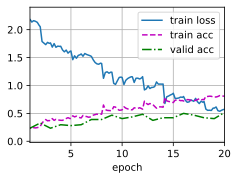

In [15]:
#  训练和验证模型
''' 
现在，我们可以训练和验证模型了，⽽以下所有超参数都可以调整。例如，我们可以增加周期的数量。
当lr_period和lr_decay分别设置为4和0.9时，优化算法的学习速率将在每4个周期乘以0.9。为便于演⽰，
我们在这⾥只训练20个周期
'''
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

train loss0.616,train acc 0.773
1427.9examples/sec on [device(type='cuda', index=0)]


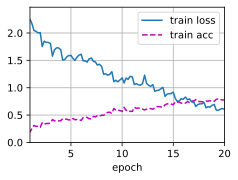

In [16]:
''' 
在获得具有超参数的满意的模型后，我们使⽤所有标记的数据（包括验证集）
即 train_valid_iter 来重新训练模型并对测试集进⾏分类
'''
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,lr_decay)

In [17]:
# 在 Kaggle 上对测试集进⾏分类并提交结果
for X, _ in test_iter: # 逐个从测试迭代器中拿到数据X
    y_hat = net(X.to(devices[0])) # 将 X 放到GPU上后进行预测
    # extend方法只能接收list，且把这个list中的每个元素添加到原list中
    # append方法可以接收任意数据类型的参数，并且简单地追加到list尾部
    ''' 
    A = ['q', 'w', 'e', 'r']
    A.extend(['t', 'y'])
    print(A)
    # ['q', 'w', 'e', 'r', 't', 'y']
    print(len(A)) # 6
    
    B = ['q', 'w', 'e', 'r']
    B.append(['t', 'y'])
    print(B)
    # ['q', 'w', 'e', 'r', ['t', 'y']]
    print(len(B)) # 5
    '''
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy()) # 求出概率最大的标签


In [18]:

sorted_ids = list(range(1, len(test_ds) + 1)) # 生成一个大小为测试集的列表
print(sorted_ids) # -> [1, 2, 3, 4, 5]
type(sorted_ids[0])

[1, 2, 3, 4, 5]


int

In [19]:
'''
sort 是应用在 list 上的方法，sorted 可以对所有可迭代的对象进行排序操作

lambda是一个隐函数，是固定写法，不要写成别的单词；
x表示列表中的一个元素，x只是临时起的一个名字，你可以使用任意的名字；
'''
sorted_ids.sort(key=lambda x: str(x)) # 对列表内的元素进行排序
print(sorted_ids) # -> [1, 2, 3, 4, 5]
type(sorted_ids[0])


[1, 2, 3, 4, 5]


int

In [20]:

df = pd.DataFrame({'id': sorted_ids, 'label': preds}) # DataFrame 构建表格
# 将df中表示 label 的数字序号转换为 label 的类别名称
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
print(train_valid_ds.classes[:])


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [21]:
df.to_csv('submission.csv', index=False) # 转换成csv进行保存，方便提交预测结果

In [22]:
''' 
向Kaggle提交结果的⽅法与 4.10节中的⽅法类似，上⾯的代码将⽣成⼀个 submission.csv⽂件，其格式
符合Kaggle竞赛的要求
--------------------------------------------------------------------------------------------
⼩结
• 将包含原始图像⽂件的数据集组织为所需格式后，我们可以读取它们
• 我们可以在图像分类竞赛中使⽤卷积神经⽹络和图像增⼴
'''

' \n向Kaggle提交结果的⽅法与 4.10节中的⽅法类似，上⾯的代码将⽣成⼀个 submission.csv⽂件，其格式\n符合Kaggle竞赛的要求\n--------------------------------------------------------------------------------------------\n⼩结\n• 将包含原始图像⽂件的数据集组织为所需格式后，我们可以读取它们\n• 我们可以在图像分类竞赛中使⽤卷积神经⽹络和图像增⼴\n'